In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
import scipy.special
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from dml_ate_iv import DMLATEIV

# Synthetic Data Generation - TripAdvisor

- Used for generating data that looks similar in structure (value distributions of private features are not representative of true data) to the data used for the intent-to-treat A/B test at TripAdvisor. 

In [4]:
import numpy as np
import pandas as pd
import locale

n = 10000  # Generated dataset size
np.random.seed(123)

X_colnames = {
    'days_visited_exp_pre': 'day_count_pre',  # How many days did they visit TripAdvisor attractions pages in the pre-period
    'days_visited_free_pre': 'day_count_pre',  # How many days did they visit TripAdvisor through free channels (e.g. domain direct) in the pre-period
    'days_visited_fs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor fs pages in the pre-period    
    'days_visited_hs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor hotels pages in the pre-period
    'days_visited_rs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor restaurant pages in the pre-period
    'days_visited_vrs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor vrs pages in the pre-period
    'is_existing_member': 'binary', #Binary indicator of whether they are existing member
    'locale_en_US': 'binary',  # User's locale
    'os_type': 'os',  # User's operating system
    'revenue_pre': 'revenue',  # Revenue in the pre-period
}

treat_colnames = {
    'treatment': 'binary',  # Did they receive the easier sign-up process in the experiment? [This is the instrument]
    'is_member': 'is_member'  # Did they become a member during the experiment period (through any means)? [This is the treatment of interest]
}

outcome_colnames = {
    'days_visited': 'days_visited',  # How many days did they visit TripAdvisor in the experimental period
}


In [5]:
def gen_data(data_type, n):
    gen_func = {'day_count_pre': lambda: np.random.randint(0, 29 , n),  # Pre-experiment period was 28 days
                'day_count_post': lambda: np.random.randint(0, 15, n),  # Experiment ran for 14 days
                'os': lambda: np.random.choice(['osx', 'windows', 'linux'], n),
                'locale': lambda: np.random.choice(list(locale.locale_alias.keys()), n),
                'count': lambda: np.random.lognormal(1, 1, n).astype('int'),
                'binary': lambda: np.random.binomial(1, .5, size=(n,)),
                ##'days_visited': lambda: 
                'revenue': lambda: np.round(np.random.lognormal(0, 3, n), 2)
                
               }
    
    return gen_func[data_type]() if data_type else None


In [10]:
X_data = {colname: gen_data(datatype, n) for colname, datatype in X_colnames.items()}
##treat_data = {colname: gen_data(datatype, N) for colname, datatype in treat_colnames.items()}
##outcome_data = {colname: gen_data(datatype, N) for colname, datatype in outcome_colnames.items()}

In [11]:
X_data=pd.DataFrame({**X_data})
# Turn strings into categories for numeric mapping
X_data['os_type'] = X_data.os_type.astype('category').cat.codes
print(X_data.columns.values)

['days_visited_exp_pre' 'days_visited_free_pre' 'days_visited_fs_pre'
 'days_visited_hs_pre' 'days_visited_rs_pre' 'days_visited_vrs_pre'
 'is_existing_member' 'locale_en_US' 'os_type' 'revenue_pre']


In [12]:
X_pre=X_data.values.astype('float')

In [13]:
def dgp_binary(X,n,true_fn):
    ##X = np.random.uniform(-1, 1, size=(n, d))
    Z = np.random.binomial(1, .5, size=(n,))
    nu = np.random.uniform(-5, 5, size=(n,))
    coef_Z = 0.6
    plt.title("Pr[T=1 | Z=1, X] vs Pr[T=1 | Z=0, X]")
    plt.scatter(X[:, 0], coef_Z*scipy.special.expit(0.4*X[:, 0] + nu))
    plt.scatter(X[:, 0], .1*np.ones(X.shape[0]))
    plt.show()
    C = np.random.binomial(1, coef_Z*scipy.special.expit(0.4*X[:, 0] + nu)) # Compliers when recomended
    C0 = np.random.binomial(1, .006*np.ones(X.shape[0])) # Non-compliers when not recommended 
    T = C * Z + C0 * (1 - Z)
    y = true_fn(X) * T + 2*nu + 5*(X[:, 0]>0) + 0.1*np.random.uniform(0, 1, size=(n,))
    return y, T, Z
true_fn = lambda X: (.8 + X[:,0]*(X[:,0]>15))# - 3*X[:, 6])

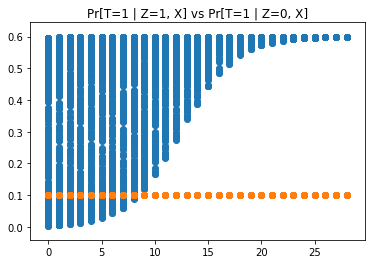

In [14]:
y, T, Z = dgp_binary(X_pre, n, true_fn)

In [15]:
X = QuantileTransformer(subsample=100000).fit_transform(X_pre)

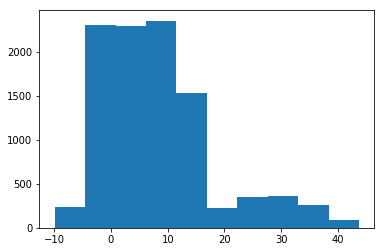

In [16]:
#### y menas number of days visit TripAdvisor in the experimental period, should be in range [0,14], 
##should be strong right skewed
plt.hist(y)
plt.show()

In [17]:
print("True ATE: {:.3f}".format(np.mean(true_fn(X_pre))))

True ATE: 10.710


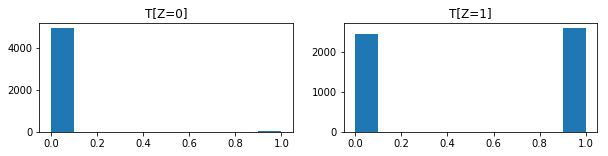

In [18]:
plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(T[Z==0])
plt.title("T[Z=0]")
plt.subplot(1, 2, 2)
plt.hist(T[Z==1])
plt.title("T[Z=1]")
plt.show()

In [19]:
print("New members: in treatment = {:f}, in control = {:f}".format(T[Z == 1].sum()/Z.sum(), T[Z == 0].sum()/(1-Z).sum()))

New members: in treatment = 0.514747, in control = 0.006423


In [20]:
print("Z treatment proportion: {:.5f}".format(np.mean(Z)))

Z treatment proportion: 0.50180


### Defining some generic regressors and classifiers

In [21]:
from dml_ate_iv import DMLATEIV
from utilities import RegWrapper, SeparateModel
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn import metrics
from xgboost import XGBClassifier, XGBRegressor
from xgb_utilities import XGBWrapper


# Define a generic non-parametric regressor
#model = lambda: GradientBoostingRegressor(n_estimators=20, max_depth=3, min_samples_leaf=20,
#                                         n_iter_no_change=5, min_impurity_decrease=.001, tol=0.001)
model = lambda: XGBWrapper(XGBRegressor(gamma=0.001, n_estimators=100, min_child_weight=50, n_jobs=10),
                           early_stopping_rounds=5, eval_metric='rmse', binary=False)

# model = lambda: RandomForestRegressor(n_estimators=100)
# model = lambda: Lasso(alpha=0.0001) #CV(cv=5)
# model = lambda: GradientBoostingRegressor(n_estimators=60)
# model = lambda: LinearRegression(n_jobs=-1)
# model = lambda: LassoCV(cv=5, n_jobs=-1)

# Define a generic non-parametric classifier. We have to wrap it with the RegWrapper, because
# we want to use predict_proba and not predict. The RegWrapper calls predict_proba of the
# underlying model whenever predict is called.
#model_clf = lambda: RegWrapper(GradientBoostingClassifier(n_estimators=20, max_depth=3, min_samples_leaf=20,
#                                         n_iter_no_change=5, min_impurity_decrease=.001, tol=0.001))
model_clf = lambda: RegWrapper(XGBWrapper(XGBClassifier(gamma=0.001, n_estimators=100, min_child_weight=50, n_jobs=10),
                                          early_stopping_rounds=5, eval_metric='logloss', binary=True))
# model_clf = lambda: RandomForestClassifier(n_estimators=100)
# model_clf = lambda: RegWrapper(GradientBoostingClassifier(n_estimators=60))
# model_clf = lambda: RegWrapper(LogisticRegression(C=10, penalty='l1', solver='liblinear'))
# model_clf = lambda: RegWrapper(LogisticRegressionCV(n_jobs=-1, cv=3, scoring='neg_log_loss'))

model_clf_dummy = lambda: RegWrapper(DummyClassifier(strategy='prior'))

# We need to specify models to be used for each of these residualizations
model_Y_X = lambda: model() # model for E[Y | X]
model_T_X = lambda: model_clf() # model for E[T | X]. We use a classifier since T is binary
model_Z_X = lambda: model_clf_dummy() # model for E[Z | X]. We use a classifier since Z is binary


# For DMLIV we also need a model for E[T | X, Z]. We use a classifier since T is binary
# Because Z is also binary, we could have also done a more complex model_T_XZ, where we split
# the data based on Z=1 and Z=0 and fit a separate sub-model for each case.
model_T_XZ = lambda: SeparateModel(model_clf(), model_clf())

In [22]:
def plot_separate(X, X_pre, cate):
    ones = X[:, 6]>.5
    lower = []
    upper = []
    unique_X = np.unique(X[ones, 0])
    for t in unique_X:
        upper.append(np.percentile(cate[ones & (X[:, 0]==t)], 99))
        lower.append(np.percentile(cate[ones & (X[:, 0]==t)], 1))
    p = plt.fill_between(unique_X, lower, upper, label='est1', alpha=.5)
    plt.plot(unique_X, lower, color=p.get_facecolor()[0], alpha=.5)
    plt.plot(unique_X, upper, color=p.get_facecolor()[0], alpha=.5)
    plt.scatter(X[ones, 0], true_fn(X_pre[ones]), label='true1', alpha=.8)
    ones = X[:, 6]<.5
    lower = []
    upper = []
    unique_X = np.unique(X[ones, 0])
    for t in unique_X:
        upper.append(np.percentile(cate[ones & (X[:, 0]==t)], 99))
        lower.append(np.percentile(cate[ones & (X[:, 0]==t)], 1))
    p = plt.fill_between(unique_X, lower, upper, label='est0', alpha=.5)
    plt.plot(unique_X, lower, color=p.get_facecolor()[0], alpha=.5)
    plt.plot(unique_X, upper, color=p.get_facecolor()[0], alpha=.5)
    plt.scatter(X[ones, 0], true_fn(X_pre[ones]), label='true0', alpha=.8)
    plt.legend()

# DMLATEIV

In [23]:
dmlateiv_obj = DMLATEIV(model_Y_X(), model_T_X(), model_Z_X(),
                  n_splits=10, # n_splits determines the number of splits to be used for cross-fitting.
                  binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                  binary_treatment=True # a flag whether to stratify cross-fitting by treatment
                 )

dmlateiv_obj.fit(y, T, X, Z)

In [24]:
ta_effect = dmlateiv_obj.effect()
ta_effect_conf = dmlateiv_obj.normal_effect_interval(lower=2.5, upper=97.5)

print("True ATE: {:.3f}".format(np.mean(true_fn(X_pre))))
print("Estimate: {:.3f}".format(ta_effect))
print("ATE Estimate Interval: ({:.3f}, {:.3f})".format(ta_effect_conf[0], ta_effect_conf[1]))
print("ATE Estimate Std: {:.3f}".format(dmlateiv_obj.std))

True ATE: 10.710
Estimate: 12.471
ATE Estimate Interval: (11.804, 13.138)
ATE Estimate Std: 0.340


# Exogenous Treatment Approaches

In [25]:
# Simply regressing y on T
from utilities import StatsModelLinearRegression
StatsModelLinearRegression().fit(T.reshape(-1, 1), y).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     5630.
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:25:38   Log-Likelihood:                -34896.
No. Observations:               10000   AIC:                         6.980e+04
Df Residuals:                    9998   BIC:                         6.981e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5161      0.092     48.936      0.000       4.335       4.697
x1            13.5406      0.180     75.030      0.000      13.187      13.894
==============================================================================
Omnibus:                       24.348   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.515
Skew:                           0.120   Prob(JB):                     4.75e-06
Kurtosis:                       2.965   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

11.925897467470786


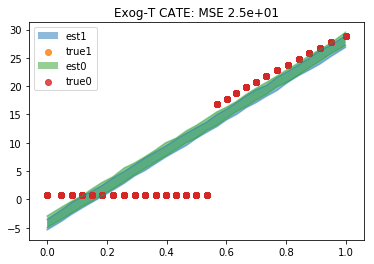

In [26]:
# Regressing y on X, X*T, T and setting CATE(X) = Pred(X, X*1, 1) - Pred(X, X*0, 0))
from econml.utilities import hstack
est = StatsModelLinearRegression().fit(hstack([X, X*T.reshape(-1, 1), T.reshape(-1, 1)]), y)
T_one = np.ones(T.shape[0])
T_zero = np.zeros(T.shape[0])
driv_cate = est.predict(hstack([X, X*T_one.reshape(-1, 1), T_one.reshape(-1, 1)]))-\
            est.predict(hstack([X, X*T_zero.reshape(-1, 1), T_zero.reshape(-1, 1)]))
print(np.mean(driv_cate))
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("Exog-T CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - driv_cate)**2)))
plot_separate(X, X_pre, driv_cate)
plt.show()

12.426392029432668


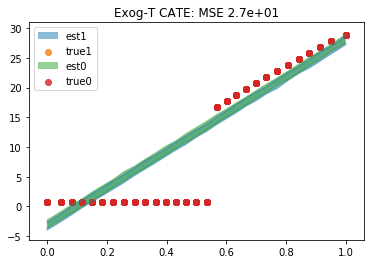

In [27]:
# Doing a full fledged DML for conditionally exogenous treatment
from econml.dml import DML
dml = DML(model_Y_X(), model_T_X(), LassoCV(cv=3))
dml.fit(y, T, X)
dml_cate = dml.effect(X)
print(np.mean(dml_cate))
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("Exog-T CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - dml_cate)**2)))
plot_separate(X, X_pre, dml_cate)
plt.show()

# DMLIV CATE

In [28]:
from dml_iv import DMLIV, GenericDMLIV
from utilities import SelectiveLasso, SeparateModel
from sklearn.linear_model import LassoCV
from econml.utilities import hstack

np.random.seed(123)

# We now specify the features to be used for heterogeneity. We will fit a CATE model of the form
#      theta(X) = <theta, phi(X)>
# for some set of features phi(X). The featurizer needs to support fit_transform, that takes
# X and returns phi(X). We need to include a bias if we also want a constant term.
dmliv_featurizer = lambda: PolynomialFeatures(degree=1, include_bias=True)

# Then we need to specify a model to be used for fitting the parameters theta in the linear form.
# This model will minimize the square loss:
#        (Y - E[Y|X] - <theta, phi(X)> * (E[T|X,Z] - E[T|X]))**2
# potentially with some regularization on theta. Here we use an ell_1 penalty on theta
# dmliv_model_effect = lambda: LinearRegression()

# We could also use LassoCV to select the regularization weight in the final stage with
# cross validation.
# dmliv_model_effect = lambda: LassoCV(fit_intercept=False, cv=3)

# If we also have a prior that there is no effect heterogeneity we can use a selective lasso
# that does not penalize the constant term in the CATE model
feature_inds = np.arange(1, X.shape[1]+1)
dmliv_model_effect = lambda: SelectiveLasso(feature_inds, LassoCV(cv=5, n_jobs=-1))

cate = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(), 
             dmliv_model_effect(), dmliv_featurizer(),
             n_splits=10, # number of splits to use for cross-fitting
             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
             binary_treatment=True # a flag whether to stratify cross-fitting by treatment
            )
"""
dmliv_model_effect = lambda: model()
cate = GenericDMLIV(model_Y_X(), model_T_X(), model_T_XZ(), 
             dmliv_model_effect(),
             n_splits=10, # number of splits to use for cross-fitting
             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
             binary_treatment=True # a flag whether to stratify cross-fitting by treatment
            )"""

'\ndmliv_model_effect = lambda: model()\ncate = GenericDMLIV(model_Y_X(), model_T_X(), model_T_XZ(), \n             dmliv_model_effect(),\n             n_splits=10, # number of splits to use for cross-fitting\n             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument\n             binary_treatment=True # a flag whether to stratify cross-fitting by treatment\n            )'

In [29]:
%%time
cate.fit(y, T, X, Z, store_final=True)

Wall time: 3.98 s


In [30]:
dmliv_effect = cate.effect(X)

In [31]:
# We can average the CATE to get an ATE
print("ATE Estimate: {:.3f}".format(np.mean(dmliv_effect)))
print("True ATE: {:.3f}".format(np.mean(true_fn(X_pre))))

ATE Estimate: 10.817
True ATE: 10.710


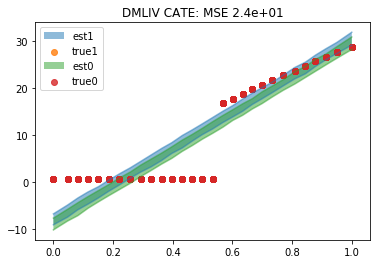

In [32]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("DMLIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - dmliv_effect)**2)))
plot_separate(X, X_pre, dmliv_effect)
plt.show()

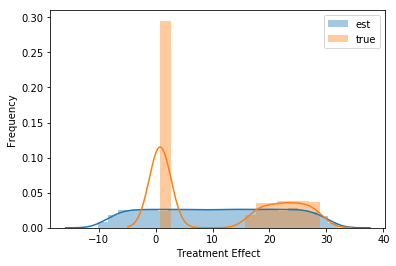

In [33]:
##histogram of estimated treatment effect
import seaborn as sns

sns.distplot(dmliv_effect, label='est')
sns.distplot(true_fn(X_pre), label='true')
plt.legend()
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

# Algorithm 3 - DRIV ATE

In [34]:
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel
from dr_iv import IntentToTreatDRIV
from utilities import WeightWrapper

np.random.seed(123)

# For intent to treat DRIV we need a flexible model of the CATE to be used in the preliminary estimation.
# This flexible model needs to accept sample weights at fit time. Here we use a weightWrapper to wrap
# a lasso estimator. WeightWrapper requires a linear model with no intercept, hence the Pipeline
# that adds a bias to the features.
driv_flexible_model_effect = lambda: WeightWrapper(Pipeline([('bias', PolynomialFeatures(degree=1, include_bias=True)),
                                      ('lasso',  SelectiveLasso(np.arange(1, X.shape[1]+1), LassoCV(cv=5, n_jobs=-1)))]))
# Then we can also define any final model to project to. Here we project to a constant model to get an ATE
driv_final_model_effect = lambda: ConstantModel()

dr_cate = IntentToTreatDRIV(model_Y_X(), model_T_XZ(),
                            driv_flexible_model_effect(),
                            final_model_effect=driv_final_model_effect(),
                            cov_clip=0.0001,
                            n_splits=10)

In [35]:
%%time
dr_cate.fit(y, T, X, Z, store_final=True)

Wall time: 7.64 s


In [36]:
dr_cate.effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Fri, 07 Jun 2019   Prob (F-statistic):                nan
Time:                        20:26:17   Log-Likelihood:                -47367.
No. Observations:               10000   AIC:                         9.474e+04
Df Residuals:                    9999   BIC:                         9.474e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8518      0.276     39.319      0.000      10.311      11.393
==============================================================================
Omnibus:                      305.981   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.801
Skew:                          -0.237   Prob(JB):                     1.24e-45
Kurtosis:                       2.478   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
lr = LinearRegression().fit(X, true_fn(X_pre))
print(lr.coef_)
print(lr.intercept_)

[ 3.51178355e+01  9.93516195e-02  1.20372976e-01  4.65886192e-02
 -2.40943550e-01 -2.89931484e-02 -1.53903712e-01 -6.79011889e-02
  8.13619639e-02 -1.64333613e-01]
-6.696210866883943


#### Projecting to subset

In [38]:
from utilities import WeightWrapper
subset_names = X_data.columns.values
#subset_names = set(['days_visited_as_pre', 'is_existing_member'])
# list of indices of features X to use in the final model
feature_inds = np.argwhere([(x in subset_names) for x in X_data.columns.values]).flatten()
print(feature_inds)
# Because we are projecting to a low dimensional model space, we can
# do valid inference and we can use statsmodel linear regression to get all
# the hypothesis testing capability
lr_driv_model_effect = lambda: SubsetWrapper(StatsModelLinearRegression(),
                                          feature_inds # list of indices of features X to use in the final model
                                         )
dr_cate.refit_final(lr_driv_model_effect())

[0 1 2 3 4 5 6 7 8 9]


In [39]:
driv_cate = dr_cate.effect(X[:, feature_inds])

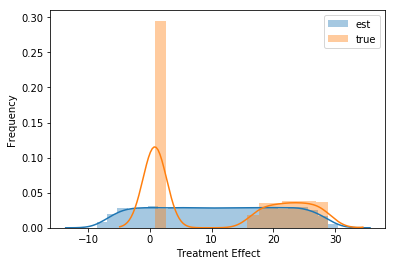

In [40]:
##histogram of estimated treatment effect
import seaborn as sns

sns.distplot(driv_cate, label='est')
sns.distplot(true_fn(X_pre), label='true')
plt.legend()
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

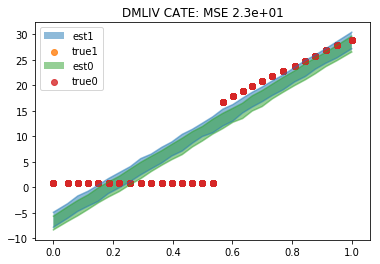

In [41]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("DMLIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - driv_cate)**2)))
plot_separate(X, X_pre, driv_cate)
plt.show()

In [42]:
# To get the ATE we look at the params of the fitted statsmodel
dr_effect = np.mean(driv_cate)
dr_effect

10.85178218531559

In [43]:
# To get the statsmodel summary we look at the effect_model, which is the pipeline, we then look
# at the reg step of the pipeline which is the statsmodel wrapper and then we look
# at the model attribute of the statsmodel wrapper and print the summary()
dr_cate.effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     158.2
Date:                Fri, 07 Jun 2019   Prob (F-statistic):          1.14e-309
Time:                        20:26:29   Log-Likelihood:                -46632.
No. Observations:               10000   AIC:                         9.329e+04
Df Residuals:                    9989   BIC:                         9.336e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5660      1.292     -4.309      0.000      -8.098      -3.034
x1            35.0479      0.885     39.615      0.000      33.314      36.782
x2             0.0634      0.883      0.072      0.943      -1.668       1.795
x3            -1.8130      0.883     -2.053      0.040      -3.544      -0.082
x4            -0.4922      0.883     -0.557      0.577      -2.223       1.239
x5            -1.3540      0.883     -1.533      0.125      -3.085       0.377
x6             0.5077      0.883      0.575      0.565      -1.223       2.239
x7             0.6324      0.514      1.231      0.218      -0.374       1.639
x8            -0.1330      0.513     -0.259      0.796      -1.139       0.873
x9             0.3405      0.625      0.545      0.586      -0.885       1.566
x10            0.0426      0.885      0.048      0.962      -1.692       1.777
==============================================================================
Omnibus:                      192.935   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.259
Skew:                           0.047   Prob(JB):                     5.12e-24
Kurtosis:                       2.502   Cond. No.                         11.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
print("ATE Estimate: {:.2f}".format(dr_effect))
print("True ATE: {:.2f}".format(np.mean(true_fn(X_pre))))

ATE Estimate: 10.85
True ATE: 10.71


In [45]:
lr = LinearRegression().fit(X[:, feature_inds], true_fn(X_pre).reshape(-1, 1))
print(lr.coef_)
print(lr.intercept_)

[[ 3.51178355e+01  9.93516195e-02  1.20372976e-01  4.65886192e-02
  -2.40943550e-01 -2.89931484e-02 -1.53903712e-01 -6.79011889e-02
   8.13619639e-02 -1.64333613e-01]]
[-6.69621087]


Coverage of True Projection: 0.97


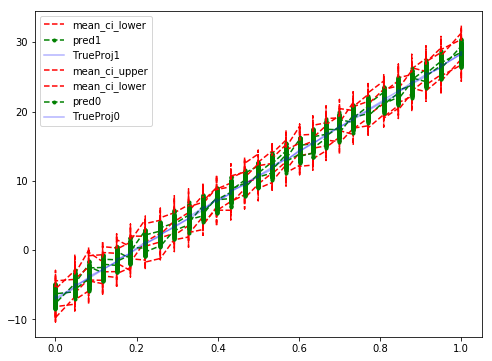

In [46]:
# We can also evaluate coverage and create prediction intervals using statsmodels attributes
from statsmodels.sandbox.regression.predstd import wls_prediction_std
res = dr_cate.effect_model.model
predictions = res.get_prediction(PolynomialFeatures(degree=1, include_bias=True).fit_transform(X[:, feature_inds]))
frame = predictions.summary_frame(alpha=0.05)
pred = frame['mean']
iv_l = frame['mean_ci_lower']
iv_u = frame['mean_ci_upper']

# This is the true CATE functions
theta_true = true_fn(X_pre)
# This is the true projection of the CATE function on the subspace of linear functions of the
# subset of the features used in the projection
true_proj = LinearRegression().fit(X[:, feature_inds], theta_true).predict(X[:, feature_inds])

# Are we covering the true projection
covered = (true_proj <= iv_u) & (true_proj >= iv_l)
print("Coverage of True Projection: {:.2f}".format(np.mean(covered)))

fig, ax = plt.subplots(figsize=(8,6))

ones = X[:, 6] > .5
order = np.argsort(X[:, feature_inds[0]])
order = order[ones[order]]
ax.plot(X[order, feature_inds[0]], np.array(iv_u[order]), 'r--')
ax.plot(X[order, feature_inds[0]], iv_l[order], 'r--')
ax.plot(X[order, feature_inds[0]], pred[order], 'g--.', label="pred1")
#ax.plot(X[order, feature_inds[0]], theta_true[order], 'b-', label="True", alpha=.3)
ax.plot(X[order, feature_inds[0]], true_proj[order], 'b-', label="TrueProj1", alpha=.3)

ones = X[:, 6] < .5
order = np.argsort(X[:, feature_inds[0]])
order = order[ones[order]]
ax.plot(X[order, feature_inds[0]], iv_u[order], 'r--')
ax.plot(X[order, feature_inds[0]], iv_l[order], 'r--')
ax.plot(X[order, feature_inds[0]], pred[order], 'g--.', label="pred0")
#ax.plot(X[order, feature_inds[0]], theta_true[order], 'b-', label="True", alpha=.3)
ax.plot(X[order, feature_inds[0]], true_proj[order], 'b-', label="TrueProj0", alpha=.3)
ax.legend(loc='best')
plt.show()
ax.legend(loc='best')
plt.show()

### Lasso Final CATE

In [47]:
lasso_driv_model_effect = lambda: WeightWrapper(Pipeline([('bias', PolynomialFeatures(degree=1, include_bias=True)),
                                      ('lasso',  SelectiveLasso(np.arange(1, X.shape[1]+1),
                                                                LassoCV(cv=5, n_jobs=-1, fit_intercept=False)))]))
dr_cate.refit_final(lasso_driv_model_effect())

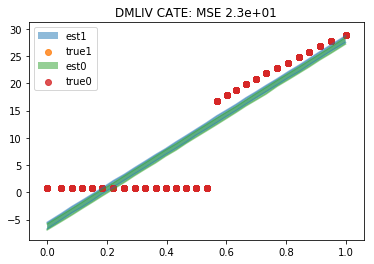

In [48]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
dr_effect = dr_cate.effect(X)
plt.title("DMLIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - dr_effect)**2)))
plot_separate(X, X_pre, dr_effect)
plt.show()

### Random Forest Based CATE and Tree Explainer

In [49]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

np.random.seed(123)

# We need a model for the final regression that will fit the function theta(X)
# Now we use a linear model and a lasso.
rf_driv_model_effect = lambda: RandomForestRegressor(n_estimators=100, max_depth=3, min_impurity_decrease=0.1,
                                                     min_samples_leaf=500, bootstrap=True)

In [50]:
rf_dr_cate = dr_cate.refit_final(rf_driv_model_effect())

In [51]:
rf_dr_effect = rf_dr_cate.effect(X)

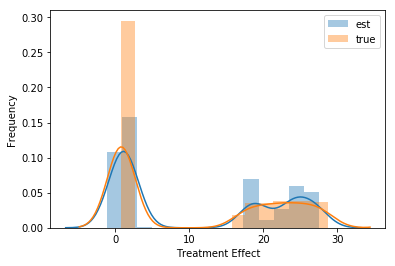

In [52]:
##histogram of estimated treatment effect
import seaborn as sns

sns.distplot(rf_dr_effect, label='est')
sns.distplot(true_fn(X_pre), label='true')
plt.legend()
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

In [53]:
print("ATE Estimate: {:.2f}".format(np.mean(rf_dr_effect)))
print("True ATE: {:.2f}".format(np.mean(true_fn(X_pre))))

ATE Estimate: 10.88
True ATE: 10.71


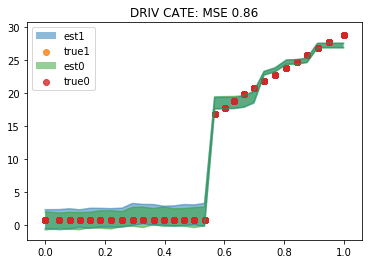

In [54]:
plt.title("DRIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - rf_dr_effect)**2)))
plot_separate(X, X_pre, rf_dr_effect)
plt.show()

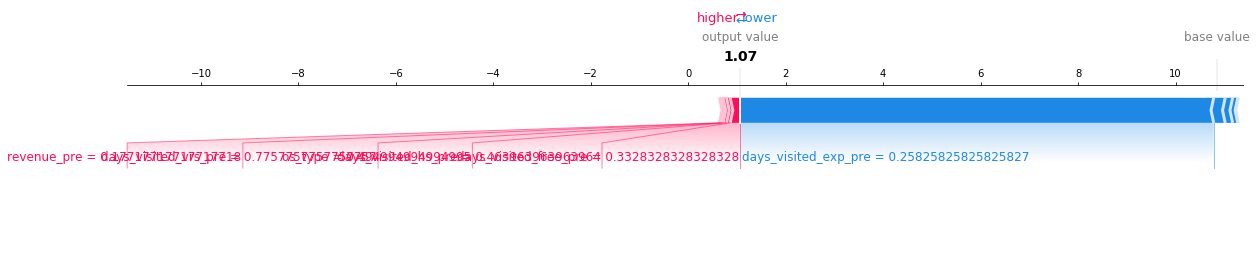

In [55]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X, columns=X_data.columns)
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_dr_cate.effect_model)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

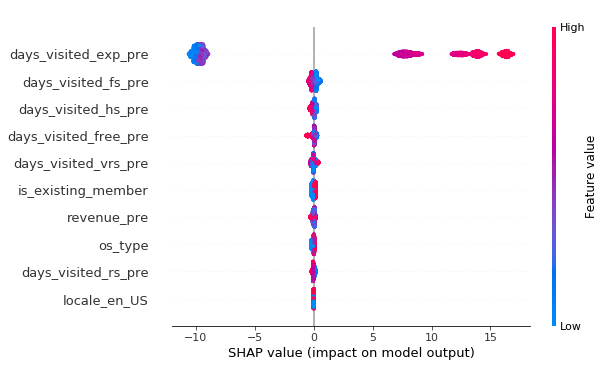

In [56]:
shap.summary_plot(shap_values, Xdf)

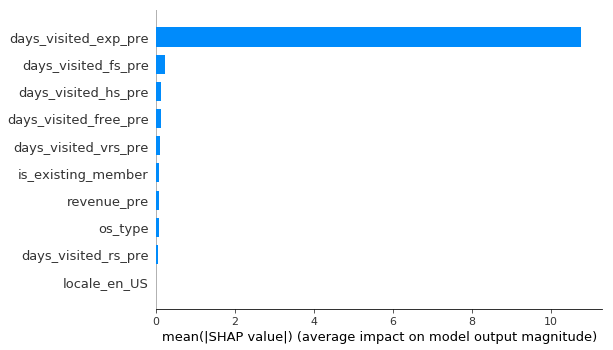

In [57]:
shap.summary_plot(shap_values, Xdf, plot_type='bar')

# CATE  with DRIV-RW

In [58]:
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel, HonestForest
from dr_iv import IntentToTreatDRIV
from utilities import WeightWrapper

np.random.seed(123)

# For intent to treat DRIV we need a flexible model of the CATE to be used in the preliminary estimation.
# This flexible model needs to accept sample weights at fit time. Here we use a weightWrapper to wrap
# a lasso estimator. WeightWrapper requires a linear model with no intercept, hence the Pipeline
# that adds a bias to the features.
rf_driv_model_effect = lambda: HonestForest(RandomForestRegressor(n_estimators=100, max_depth=6, min_impurity_decrease=0.001,
                                                     min_samples_leaf=100, bootstrap=True))

rf_dr_cate = IntentToTreatDRIV(model_Y_X(), model_T_XZ(),
                            rf_driv_model_effect(),
                            opt_reweighted=True, # re-weighting the final loss for variance reduction
                            cov_clip=1e-4,
                            n_splits=10)

In [59]:
%%time
rf_dr_cate.fit(y, T, X, Z, store_final=True)

Wall time: 12.1 s


In [60]:
rf_dr_effect = rf_dr_cate.effect(X)

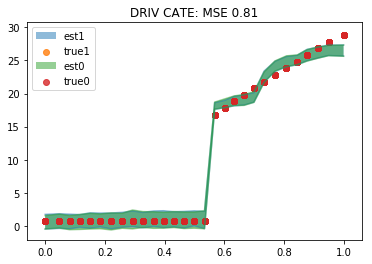

In [61]:
plt.title("DRIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - rf_dr_effect)**2)))
plot_separate(X, X_pre, rf_dr_effect)
plt.show()

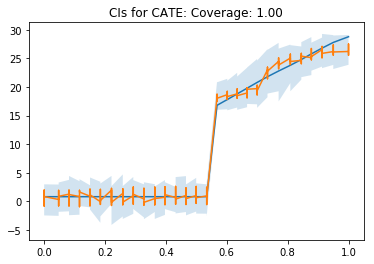

In [62]:
lower, upper = rf_dr_cate.effect_model.predict_interval(X)
plt.title("CIs for CATE: Coverage: {:.2f}".format(np.mean((lower <= true_fn(X_pre)) & (upper >= true_fn(X_pre)))))
sorted_ind = np.argsort(X[:, 0])
plt.fill_between(X[sorted_ind, 0], lower[sorted_ind], upper[sorted_ind], alpha=.2)
plt.plot(X[sorted_ind, 0], true_fn(X_pre[sorted_ind]), label='true')
plt.plot(X[sorted_ind, 0], rf_dr_effect[sorted_ind], label='est')
plt.show()

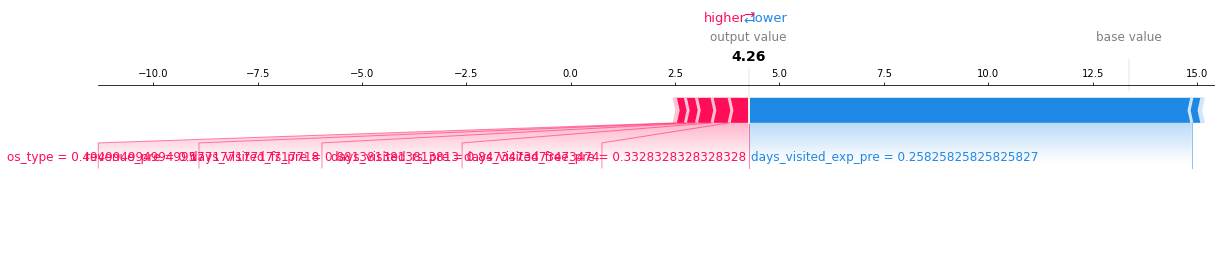

In [63]:
import shap
import pandas as pd
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor

Xdf = pd.DataFrame(X, columns=X_data.columns)
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_dr_cate.effect_model.forest)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

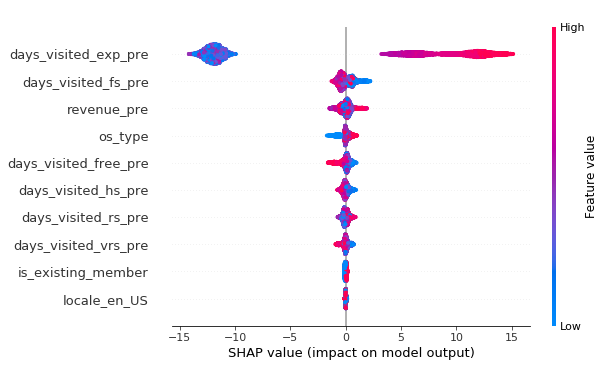

In [64]:
shap.summary_plot(shap_values, Xdf)

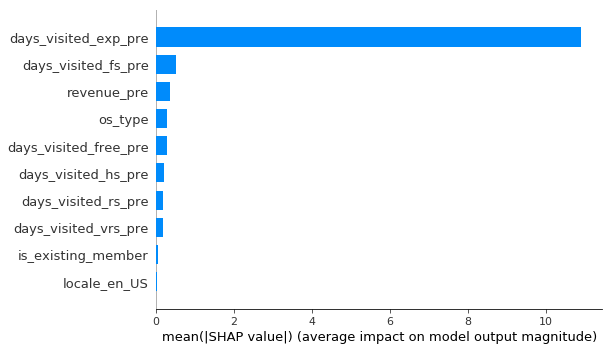

In [65]:
shap.summary_plot(shap_values, Xdf, plot_type='bar')

In [71]:
from utilities import ConstantModel
rf_dr_cate.refit_final(ConstantModel(), opt_reweighted=False)
rf_dr_cate.effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Fri, 07 Jun 2019   Prob (F-statistic):                nan
Time:                        20:29:07   Log-Likelihood:                -46991.
No. Observations:               10000   AIC:                         9.398e+04
Df Residuals:                    9999   BIC:                         9.399e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9125      0.266     41.052      0.000      10.391      11.434
==============================================================================
Omnibus:                      464.249   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.490
Skew:                          -0.234   Prob(JB):                     2.01e-56
Kurtosis:                       2.370   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Using Generic DRIV

In [72]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel

np.random.seed(123)

# For DRIV we need a model for predicting E[T*Z | X]. We use a classifier
model_TZ_X = lambda: model_clf()

# For generic DRIV we also need to provide a preliminary effect model. Here we use DMLIV
dmliv_featurizer = lambda: PolynomialFeatures(degree=1, include_bias=True)
dmliv_model_effect = lambda: SelectiveLasso(np.arange(1, X.shape[1]+1), LassoCV(cv=5, n_jobs=-1))
prel_model_effect = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(),
                          dmliv_model_effect(), dmliv_featurizer(), n_splits=1)

dr_cate = DRIV(model_Y_X(), model_T_X(), model_Z_X(), # same as in DMLATEIV
                        prel_model_effect, # preliminary model for CATE, must support fit(y, T, X, Z) and effect(X)
                        model_TZ_X(), # model for E[T * Z | X]
                        ConstantModel(), # model for final stage of fitting theta(X)
                        cov_clip=.0001, # covariance clipping to avoid large values in final regression from weak instruments
                        n_splits=10, # number of splits to use for cross-fitting
                        binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                        binary_treatment=True, # a flag whether to stratify cross-fitting by treatment
                        opt_reweighted=False
                       )

In [73]:
%%time
dr_cate.fit(y, T, X, Z, store_final=True)

Wall time: 9.63 s


In [74]:
dr_cate.effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Fri, 07 Jun 2019   Prob (F-statistic):                nan
Time:                        20:29:19   Log-Likelihood:                -47493.
No. Observations:               10000   AIC:                         9.499e+04
Df Residuals:                    9999   BIC:                         9.500e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8649      0.280     38.872      0.000      10.317      11.413
==============================================================================
Omnibus:                      101.664   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.449
Skew:                          -0.248   Prob(JB):                     2.08e-23
Kurtosis:                       2.929   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Deep CATE Models

In [75]:
from deep_dr_iv import DeepIntentToTreatDRIV
import keras
treatment_model = lambda: keras.Sequential([keras.layers.Dense(1000, activation='relu'),
                                            keras.layers.Dropout(0.17),
                                            keras.layers.Dense(1)])
keras_fit_options = { "epochs": 100,
                      "batch_size": 32,
                      "validation_split": 0.1,
                      "callbacks": [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                      "verbose": 0}
dr_cate = DeepIntentToTreatDRIV(model_Y_X(), model_T_XZ(),
                                treatment_model(),
                                training_options=keras_fit_options,
                                cov_clip=0.0001,
                                opt_reweighted=False,
                                n_splits=3)

Using TensorFlow backend.


In [76]:
%%time
dr_cate.fit(y, T, X, Z, store_final=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Wall time: 1min 6s


In [77]:
dr_effect = dr_cate.effect(X)

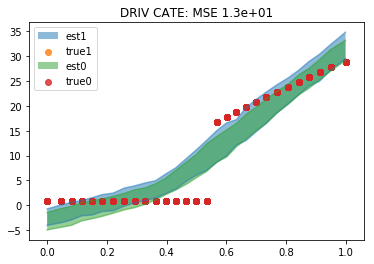

In [78]:
plt.title("DRIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - dr_effect)**2)))
plot_separate(X, X_pre, dr_effect)
plt.show()

In [79]:
from utilities import ConstantModel
dr_cate.refit_final(ConstantModel(), opt_reweighted=False)

In [80]:
dr_cate.effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Fri, 07 Jun 2019   Prob (F-statistic):                nan
Time:                        20:30:41   Log-Likelihood:                -47448.
No. Observations:               10000   AIC:                         9.490e+04
Df Residuals:                    9999   BIC:                         9.490e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9521      0.278     39.363      0.000      10.407      11.498
==============================================================================
Omnibus:                      295.156   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.622
Skew:                          -0.242   Prob(JB):                     2.24e-45
Kurtosis:                       2.492   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""